<a href="https://www.kaggle.com/code/handandegerli/arl-recommendation-system?scriptVersionId=182213819" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install openpyxl

In [2]:
############################################
# ASSOCIATION RULE LEARNING (BİRLİKTELİK KURALI ÖĞRENİMİ) Sepet analizi(online offline e ticaret sir kul.)
############################################

# 1. Veri Ön İşleme
# 2. ARL Veri Yapısını Hazırlama (Invoice-Product Matrix)
# 3. Birliktelik Kurallarının Çıkarılması
# 4. Çalışmanın Scriptini Hazırlama
# 5. Sepet Aşamasındaki Kullanıcılara Ürün Önerisinde Bulunmak

############################################
# 1. Veri Ön İşleme
############################################

# !pip install mlxtend
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
# çıktının tek bir satırda olmasını sağlar.
pd.set_option('display.expand_frame_repr', False)
from mlxtend.frequent_patterns import apriori, association_rules

# https://archive.ics.uci.edu/ml/datasets/Online+Retail+II


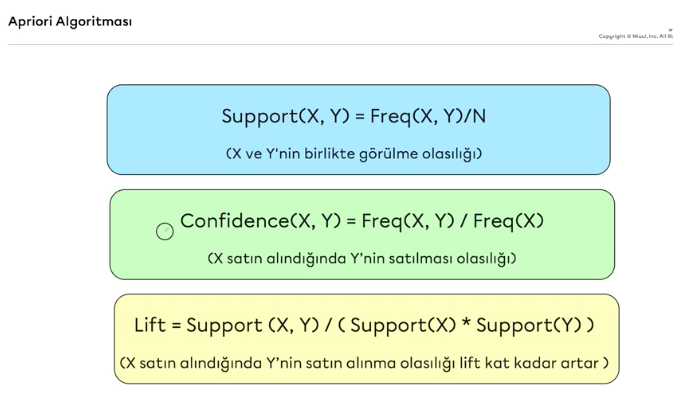

In [3]:
df_ = pd.read_excel("/kaggle/input/dataset-arb-recommendation-system/online_retail_II.xlsx",
                    sheet_name="Year 2010-2011")
#hata alıyorsak
# df_ = pd.read_excel("datasets/online_retail_II.xlsx",
#                     sheet_name="Year 2010-2011", engine="openpyxl")

In [4]:
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,541910.0,9.552234,-80995.0,1.0,3.0,10.0,80995.0,218.080957
InvoiceDate,541910,2011-07-04 13:35:22.342307584,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
Price,541910.0,4.611138,-11062.06,1.25,2.08,4.13,38970.0,96.759765
Customer ID,406830.0,15287.68416,12346.0,13953.0,15152.0,16791.0,18287.0,1713.603074


In [6]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [7]:
df.shape

(541910, 8)

In [8]:
#def retail_data_prep(dataframe):
#   dataframe.dropna(inplace=True)
#    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
#    dataframe = dataframe[dataframe["Quantity"] > 0]
#   dataframe = dataframe[dataframe["Price"] > 0]
#    return dataframe

#df = retail_data_prep(df)

In [9]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [10]:
def retail_data_prep(dataframe):
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    return dataframe

df = retail_data_prep(df)

/tmp/ipykernel_18/988831746.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-177.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


In [11]:
 df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [12]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,397885.0,11.83077,1.0,2.0,6.0,12.0,298.5,25.523052
InvoiceDate,397885,2011-07-10 23:41:56.419316992,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 14:39:00,2011-10-20 14:33:00,2011-12-09 12:50:00,NaN
Price,397885.0,2.893492,0.001,1.25,1.95,3.75,37.06,3.227175
Customer ID,397885.0,15294.416882,12346.0,13969.0,15159.0,16795.0,18287.0,1713.144421


In [13]:
############################################
# 2. ARL Veri Yapısını Hazırlama (Invoice-Product Matrix)
############################################
#tümden gelim yontemiyle elimizdeki veride ne olduguna bakalım!
df.head()

# Description   NINE DRAWER OFFICE TIDY   SET 2 TEA TOWELS I LOVE LONDON    SPACEBOY BABY GIFT SET
# Invoice
# 536370                              0                                 1                       0
# 536852                              1                                 0                       1
# 536974                              0                                 0                       0
# 537065                              1                                 0                       0
# 537463                              0                                 0                       1

#invoice lar bizim sepetlerimiz transaction larımız olucak, sütunlardakiler ise ürünler olucak!

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [14]:
df_fr = df[df['Country'] == "France"]
#diyelim almanya pazarına giricez ama bilmiyoruz o ülkeyle benzer tercihler yapan fransa üzerinden arl yi fransa uzerinden kurarım ve almanya ya uygularım.

In [15]:
df_fr.groupby(['Invoice', 'Description']).agg({"Quantity": "sum"}).head(20)

Quantity
Invoice Description                                  
536370   SET 2 TEA TOWELS I LOVE LONDON          24.0
        ALARM CLOCK BAKELIKE GREEN               12.0
        ALARM CLOCK BAKELIKE PINK                24.0
        ALARM CLOCK BAKELIKE RED                 24.0
        CHARLOTTE BAG DOLLY GIRL DESIGN          20.0
        CIRCUS PARADE LUNCH BOX                  24.0
        INFLATABLE POLITICAL GLOBE               48.0
        LUNCH BOX I LOVE LONDON                  24.0
        MINI JIGSAW CIRCUS PARADE                24.0
        MINI JIGSAW SPACEBOY                     24.0
        MINI PAINT SET VINTAGE                   36.0
        PANDA AND BUNNIES STICKER SHEET          12.0
        POSTAGE                                   3.0
        RED TOADSTOOL LED NIGHT LIGHT            24.0
        ROUND SNACK BOXES SET OF4 WOODLAND       24.0
        SET/2 RED RETROSPOT TEA TOWELS           18.0
        SPACEBOY LUNCH BOX                       24.0
        STARS GIFT TAPE                          24.0
        VINTAGE HEADS AND TAILS CARD GAME        24.0
        VINTAGE SEASIDE JIGSAW PUZZLES           12.0

In [16]:
#pivot veya unstack le urunleri stun haline getiriyoruz.
df_fr.groupby(['Invoice', 'Description']).agg({"Quantity": "sum"}).unstack().iloc[0:5, 0:5]


Quantity                                                                                                      
Description 50'S CHRISTMAS GIFT BAG LARGE DOLLY GIRL BEAKER I LOVE LONDON MINI BACKPACK NINE DRAWER OFFICE TIDY SET 2 TEA TOWELS I LOVE LONDON 
Invoice                                                                                                                                        
536370                                NaN               NaN                         NaN                     NaN                            24.0
536852                                NaN               NaN                         NaN                     NaN                             NaN
536974                                NaN               NaN                         NaN                     NaN                             NaN
537065                                NaN               NaN                         NaN                     NaN                             NaN
537463                                NaN               NaN                         NaN                     NaN                             NaN

In [17]:
df_fr.groupby(['Invoice', 'Description']).agg({"Quantity": "sum"}).unstack().fillna(0).iloc[0:5, 0:5]


Quantity                                                                                                      
Description 50'S CHRISTMAS GIFT BAG LARGE DOLLY GIRL BEAKER I LOVE LONDON MINI BACKPACK NINE DRAWER OFFICE TIDY SET 2 TEA TOWELS I LOVE LONDON 
Invoice                                                                                                                                        
536370                                0.0               0.0                         0.0                     0.0                            24.0
536852                                0.0               0.0                         0.0                     0.0                             0.0
536974                                0.0               0.0                         0.0                     0.0                             0.0
537065                                0.0               0.0                         0.0                     0.0                             0.0
537463                                0.0               0.0                         0.0                     0.0                             0.0

In [18]:
#normalde apply func satır sutun bilgisi verilir ona func uygular iterasyon yapılmasına gerek kalmadan
#ama applymap te ise tüm gözlemleri gezer

df_fr.groupby(['Invoice', 'StockCode']). \
    agg({"Quantity": "sum"}). \
    unstack(). \
    fillna(0). \
    applymap(lambda x: 1 if x > 0 else 0).iloc[0:5, 0:5]

/tmp/ipykernel_18/143097538.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  applymap(lambda x: 1 if x > 0 else 0).iloc[0:5, 0:5]


Quantity                        
StockCode    10002 10120 10125 10135 11001
Invoice                                   
536370           1     0     0     0     0
536852           0     0     0     0     0
536974           0     0     0     0     0
537065           0     0     0     0     0
537463           0     0     0     0     0

In [19]:
def create_invoice_product_df(dataframe, id=False):
    if id:
        return dataframe.groupby(['Invoice', "StockCode"])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)
    else:
        return dataframe.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)

In [20]:
fr_inv_pro_df = create_invoice_product_df(df_fr)

/tmp/ipykernel_18/3019334217.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  applymap(lambda x: 1 if x > 0 else 0)


In [21]:
fr_inv_pro_df = create_invoice_product_df(df_fr, id=True)

/tmp/ipykernel_18/3019334217.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  applymap(lambda x: 1 if x > 0 else 0)


In [22]:
#stock id için neye karsılık geliyor check için
def check_id(dataframe, stock_code):
    product_name = dataframe[dataframe["StockCode"] == stock_code][["Description"]].values[0].tolist()
    print(product_name)

In [23]:
check_id(df_fr, 10120)

['DOGGY RUBBER']


In [24]:
############################################
############################################

frequent_itemsets = apriori(fr_inv_pro_df,
                            min_support=0.01,
                            use_colnames=True)

frequent_itemsets.sort_values("support", ascending=False)

/opt/conda/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
538,0.773779,(POST)
387,0.187661,(23084)
107,0.179949,(21731)
243,0.172237,(22554)
245,0.169666,(22556)
...,...,...
18793,0.010283,"(22729, 21086, 22326, 22551)"
18787,0.010283,"(23256, 21086, 22492, 22326)"
18786,0.010283,"(22728, 21086, 22492, 22326)"
18785,0.010283,"(21086, 22492, 22326, 22727)"


In [25]:
rules = association_rules(frequent_itemsets,
                          metric="support",
                          min_threshold=0.01)
rules

#antecedents x ürünü
#consequents y ürünü
# x, y birlikte satın alınma olasılığı support
# x ürünü satın alındıgında y ürününün satın alınma olasılıgı confidence
# x ürünü satın alındıgında y ürünün satın alınma olasılıgı lift kat artmaktadır.
#leverage kaldıraç değeridir. lifte benzer ama supportu yuksek olan degerlere oncelik verme eğilimindedir. yanlıdır.
#lift daha az sıklıkta olmasına ragmen ilişkileri belirleyebilme imkanı verir Lift daha degerli yansız bir metric tir.
#conviction y ürünü olmadan x ürününün bekelnen degeri frekansıdır.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(10002),(21791),0.020566,0.028278,0.010283,0.500000,17.681818,0.009701,1.943445,0.963255
1,(21791),(10002),0.028278,0.020566,0.010283,0.363636,17.681818,0.009701,1.539111,0.970899
2,(10002),(21915),0.020566,0.069409,0.010283,0.500000,7.203704,0.008855,1.861183,0.879265
3,(21915),(10002),0.069409,0.020566,0.010283,0.148148,7.203704,0.008855,1.149771,0.925414
4,(10002),(22551),0.020566,0.136247,0.010283,0.500000,3.669811,0.007481,1.727506,0.742782
...,...,...,...,...,...,...,...,...,...,...
1372699,(23254),"(22659, 23206, 22726, 22727, 22728, 20750, 223...",0.071979,0.010283,0.010283,0.142857,13.892857,0.009543,1.154670,1.000000
1372700,(22326),"(22659, 23206, 22726, 22727, 22728, 20750, 223...",0.159383,0.010283,0.010283,0.064516,6.274194,0.008644,1.057974,1.000000
1372701,(21558),"(22659, 23206, 22726, 22727, 22728, 20750, 223...",0.051414,0.010283,0.010283,0.200000,19.450000,0.009754,1.237147,1.000000
1372702,(23291),"(22659, 23206, 22726, 22727, 22728, 20750, 223...",0.041131,0.010283,0.010283,0.250000,24.312500,0.009860,1.319623,1.000000


In [26]:
rules[(rules["support"]>0.05) & (rules["confidence"]>0.1) & (rules["lift"]>5)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1606,(21080),(21086),0.133676,0.138817,0.102828,0.769231,5.541311,0.084271,3.731791,0.945994
1607,(21086),(21080),0.138817,0.133676,0.102828,0.740741,5.541311,0.084271,3.341535,0.951642
1608,(21080),(21094),0.133676,0.128535,0.102828,0.769231,5.984615,0.085646,3.776350,0.961424
1609,(21094),(21080),0.128535,0.133676,0.102828,0.800000,5.984615,0.085646,4.331620,0.955752
1776,(21086),(21094),0.138817,0.128535,0.123393,0.888889,6.915556,0.105550,7.843188,0.993284
...,...,...,...,...,...,...,...,...,...,...
213940,"(POST, 22727)","(22728, 22726)",0.089974,0.074550,0.059126,0.657143,8.814778,0.052418,2.699229,0.974208
213941,"(22726, 22727)","(22728, POST)",0.079692,0.092545,0.059126,0.741935,8.017025,0.051751,3.516388,0.951057
213942,(22728),"(POST, 22726, 22727)",0.102828,0.074550,0.059126,0.575000,7.712931,0.051460,2.177529,0.970101
213944,(22726),"(22728, POST, 22727)",0.097686,0.069409,0.059126,0.605263,8.720273,0.052346,2.357498,0.981172


In [27]:
check_id(df_fr, 21080)

['SET/20 RED RETROSPOT PAPER NAPKINS ']


In [28]:
rules[(rules["support"]>0.05) & (rules["confidence"]>0.1) & (rules["lift"]>5)]. \
sort_values("confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
23707,"(21080, 21094)",(21086),0.102828,0.138817,0.100257,0.975000,7.023611,0.085983,34.447301,0.955918
23706,"(21080, 21086)",(21094),0.102828,0.128535,0.100257,0.975000,7.585500,0.087040,34.858612,0.967673
108820,"(21080, POST, 21086)",(21094),0.084833,0.128535,0.082262,0.969697,7.544242,0.071358,28.758355,0.947858
108822,"(21080, POST, 21094)",(21086),0.084833,0.138817,0.082262,0.969697,6.985410,0.070486,28.419023,0.936271
1777,(21094),(21086),0.128535,0.138817,0.123393,0.960000,6.915556,0.105550,21.529563,0.981563
...,...,...,...,...,...,...,...,...,...,...
7212,(22629),(22630),0.125964,0.100257,0.071979,0.571429,5.699634,0.059351,2.099400,0.943382
62249,(22630),"(POST, 22629)",0.100257,0.100257,0.053985,0.538462,5.370809,0.043933,1.949443,0.904490
62244,"(POST, 22629)",(22630),0.100257,0.100257,0.053985,0.538462,5.370809,0.043933,1.949443,0.904490
62248,(22629),"(POST, 22630)",0.125964,0.074550,0.053985,0.428571,5.748768,0.044594,1.619537,0.945098


In [29]:
df = df_.copy()
############################################
# 4. Çalışmanın Scriptini Hazırlama
############################################

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def retail_data_prep(dataframe):
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    return dataframe


def create_invoice_product_df(dataframe, id=False):
    if id:
        return dataframe.groupby(['Invoice', "StockCode"])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)
    else:
        return dataframe.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)


def check_id(dataframe, stock_code):
    product_name = dataframe[dataframe["StockCode"] == stock_code][["Description"]].values[0].tolist()
    print(product_name)


def create_rules(dataframe, id=True, country="France"):
    dataframe = dataframe[dataframe['Country'] == country]
    dataframe = create_invoice_product_df(dataframe, id)
    frequent_itemsets = apriori(dataframe, min_support=0.01, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.01)
    return rules

df = retail_data_prep(df)
rules = create_rules(df)

rules[(rules["support"]>0.05) & (rules["confidence"]>0.1) & (rules["lift"]>5)]. \
sort_values("confidence", ascending=False)

/tmp/ipykernel_18/398541034.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-177.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
/tmp/ipykernel_18/398541034.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  applymap(lambda x: 1 if x > 0 else 0)
/opt/conda/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
23707,"(21080, 21094)",(21086),0.102828,0.138817,0.100257,0.975000,7.023611,0.085983,34.447301,0.955918
23706,"(21080, 21086)",(21094),0.102828,0.128535,0.100257,0.975000,7.585500,0.087040,34.858612,0.967673
108820,"(21080, POST, 21086)",(21094),0.084833,0.128535,0.082262,0.969697,7.544242,0.071358,28.758355,0.947858
108822,"(21080, POST, 21094)",(21086),0.084833,0.138817,0.082262,0.969697,6.985410,0.070486,28.419023,0.936271
1777,(21094),(21086),0.128535,0.138817,0.123393,0.960000,6.915556,0.105550,21.529563,0.981563
...,...,...,...,...,...,...,...,...,...,...
7212,(22629),(22630),0.125964,0.100257,0.071979,0.571429,5.699634,0.059351,2.099400,0.943382
62249,(22630),"(POST, 22629)",0.100257,0.100257,0.053985,0.538462,5.370809,0.043933,1.949443,0.904490
62244,"(POST, 22629)",(22630),0.100257,0.100257,0.053985,0.538462,5.370809,0.043933,1.949443,0.904490
62248,(22629),"(POST, 22630)",0.125964,0.074550,0.053985,0.428571,5.748768,0.044594,1.619537,0.945098


In [30]:
############################################
# 5. Sepet Aşamasındaki Kullanıcılara Ürün Önerisinde Bulunmak
############################################

# Örnek:
# Kullanıcı örnek ürün id: 22492

product_id = 22492
check_id(df, product_id)


['MINI PAINT SET VINTAGE ']


In [31]:
sorted_rules = rules.sort_values("lift", ascending=False)

In [32]:
recommendation_list = []

for i, product in enumerate(sorted_rules["antecedents"]):
    for j in list(product):
        if j == product_id:
            recommendation_list.append(list(sorted_rules.iloc[i]["consequents"])[0])

recommendation_list[0:3]


[22556, 22551, 22326]

In [33]:
check_id(df, 22326)

['ROUND SNACK BOXES SET OF4 WOODLAND ']


In [34]:
def arl_recommender(rules_df, product_id, rec_count=1):
    sorted_rules = rules_df.sort_values("lift", ascending=False)
    recommendation_list = []
    for i, product in enumerate(sorted_rules["antecedents"]):
        for j in list(product):
            if j == product_id:
                recommendation_list.append(list(sorted_rules.iloc[i]["consequents"])[0])

    return recommendation_list[0:rec_count]

arl_recommender(rules, 22492, 1)

[22556]

In [35]:
arl_recommender(rules, 22492, 2)

[22556, 22551]

In [36]:
arl_recommender(rules, 22492, 3)

[22556, 22551, 22326]